## UMAP embedding of SynapseCLR representations with annotations overlaid

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cuml
from cuml import PCA, TSNE, UMAP

from synapse_utils import io, vis
from synapse_utils.commons import load_imputed_annotations, log1p_zscore

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
repo_root = '../..'
dataset_path = '../../data/MICrONS__L23__8_8_40__processed'

run_id = 'synapseclr__so3__seed_42__second_stage'
checkpoint_path = f'../../output/checkpoint__{run_id}'
contamination_indices_path = '../../tables/meta_df_contamination_indices.npy'
reload_epoch = 99
node_idx_list = [0, 1, 2, 3]

imputed_cell_types_df_path = os.path.join(
    checkpoint_path, 'analysis', 'gp', 'synapse_simclr_consensus', 'consensus__meta__uncensored.csv')
imputed_meta_ext_df_path = os.path.join(
    checkpoint_path, 'analysis', 'gp', 'synapse_simclr_production', 'imputed_meta__rbf__synapse_simclr__ensemble.csv')

In [3]:
umap_annotations_output_path = os.path.join(checkpoint_path, 'analysis', 'umap_annotations')
os.makedirs(umap_annotations_output_path, exist_ok=True)

highlighted_synapses_output_path = os.path.join(checkpoint_path, 'analysis', 'umap_annotations', 'highlighted_synapses')
os.makedirs(highlighted_synapses_output_path, exist_ok=True)

manual_umap_annotations_output_path = os.path.join(checkpoint_path, 'analysis', 'umap_annotations', 'manual')
os.makedirs(manual_umap_annotations_output_path, exist_ok=True)

imputed_umap_annotations_output_path = os.path.join(checkpoint_path, 'analysis', 'umap_annotations', 'imputed')
os.makedirs(imputed_umap_annotations_output_path, exist_ok=True)

## 2D Embedding

In [4]:
# # load features
load_prefix = 'encoder.fc'
save_prefix = load_prefix.replace('.', '_')
l2_normalize = False

features_nf, meta_df, meta_ext_df = io.load_features(
    checkpoint_path,
    node_idx_list,
    reload_epoch,
    feature_hook=load_prefix,
    dataset_path=dataset_path,
    l2_normalize=l2_normalize,
    contamination_indices_path=contamination_indices_path)

n_pca_components = 128
if n_pca_components < features_nf.shape[-1]:
    features_nf = PCA(n_components=n_pca_components).fit_transform(features_nf)

In [5]:
# (optionally) load
import pickle

embedding_type = 'UMAP'
features_n2 = np.load(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d.npy'))
    
embedding_2d_loaded = True

In [6]:
if not embedding_2d_loaded:
    
    embedding_type = 'UMAP'
    save_results = True

    # for UMAP
    n_neighbors = 500
    n_epochs = 5000
    learning_rate = 1.0
    spread = 1.0
    min_dist = 0.1

    # for t-SNE
    perplexity = 10


    if embedding_type == 'UMAP':

        umap_2d_fit = UMAP(
            min_dist=min_dist,
            spread=spread,
            n_neighbors=n_neighbors,
            learning_rate=learning_rate,
            n_epochs=n_epochs,
            random_state=42).fit(features_nf)

        features_n2 = umap_2d_fit.embedding_

        # save embedding
        import pickle

        if save_results:

            os.makedirs(os.path.join(checkpoint_path, 'embeddings'), exist_ok=True)
            with open(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d__fit.pkl'), 'wb') as f:
                pickle.dump(umap_2d_fit, f)
            np.save(
                os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__umap_2d.npy'),
                features_n2)

    elif embedding_type == 'TSNE':

        tsne_2d_fit = TSNE(
            perplexity=perplexity,
            n_neighbors=n_neighbors,
            learning_rate_method=None).fit(features_nf)

        features_n2 = tsne_2d_fit.embedding_

        # save embedding
        import pickle

        if save_results:

            os.makedirs(os.path.join(checkpoint_path, 'embeddings'), exist_ok=True)
            with open(os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__tsne_2d__fit.pkl'), 'wb') as f:
                pickle.dump(tsne_2d_fit, f)
            np.save(
                os.path.join(checkpoint_path, 'embeddings', f'{save_prefix}__tsne_2d.npy'),
                features_n2)

## Setup visualization

In [7]:
ctx = vis.SynapseVisContext(
    dataset_path,
    '../../configs/config__ext/augmenter_display.yaml',
    meta_df_override=meta_df,
    device='cuda')

## Global UMAP with a few synapses higlighted

In [8]:
# helper function
def get_row_indices_from_synapse_ids(synapse_ids):
    synapse_id_to_meta_row_idx_map = {
        synapse_id: row_idx for row_idx, synapse_id in enumerate(meta_df['synapse_id'].values)}
    return [x for x in map(synapse_id_to_meta_row_idx_map.get, synapse_ids)
            if x is not None]

In [9]:
from cuml.neighbors import NearestNeighbors

highlighted_umap_pos_list = [
    # excitatory
    (0., 11.,),
    (-8, -4.2),
    (-5.2, 6.8),
    (-3.5, 3.5),
    
    # inhibitory
    (0.7, -2.8),
    (0.7, 0.6),
    (-0.7, 1.6),
]

umap_knn_fit = NearestNeighbors(n_neighbors=5).fit(features_n2)
umap_knn_neighbors_indices = umap_knn_fit.kneighbors(np.asarray(highlighted_umap_pos_list))[1]

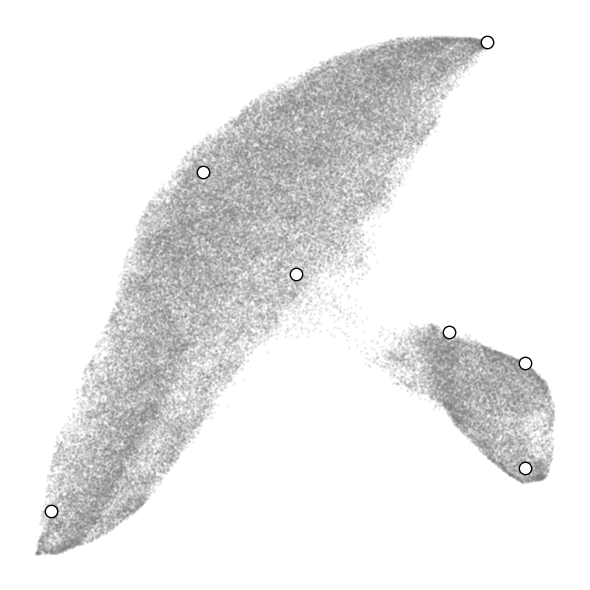

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=1.,
    vmin=-2, vmax=2,
    alpha=0.1,
    color='gray',
    rasterized=True)

sc = ax.scatter(
    list(map(lambda x: x[0], highlighted_umap_pos_list)),
    list(map(lambda x: x[1], highlighted_umap_pos_list)),
    lw=1.0,
    s=80,
    facecolor='white',
    edgecolor='black')

    
ax.set_xlabel(f'{embedding_type} 1', fontsize=14)
ax.set_ylabel(f'{embedding_type} 2', fontsize=14)
ax.axis('off')
fig.tight_layout()
fig.savefig(
    os.path.join(umap_annotations_output_path, f'umap__{save_prefix}__blank_with_highlights.pdf'),
    dpi=600,
    bbox_inches='tight')

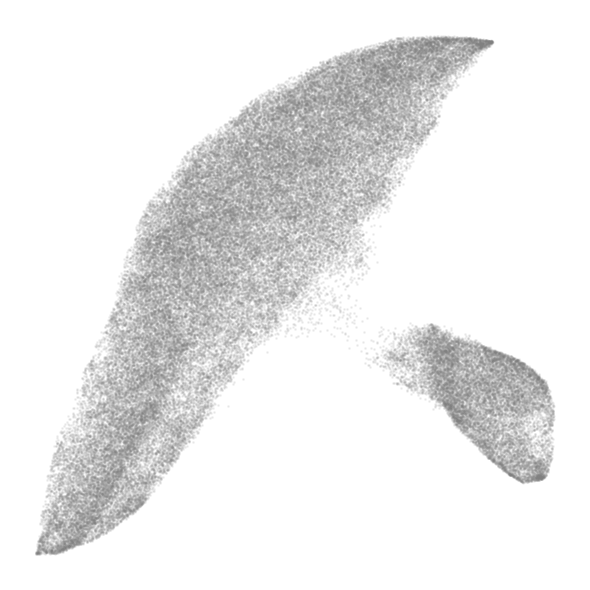

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=1.,
    vmin=-2, vmax=2,
    alpha=0.1,
    color='gray',
    rasterized=True)
    
ax.set_xlabel(f'{embedding_type} 1', fontsize=14)
ax.set_ylabel(f'{embedding_type} 2', fontsize=14)
ax.axis('off')
fig.tight_layout()
fig.savefig(
    os.path.join(umap_annotations_output_path, f'umap__{save_prefix}__blank_without_highlights.pdf'),
    dpi=600,
    bbox_inches='tight')

In [13]:
for i in range(umap_knn_neighbors_indices.shape[0]):
    for j in range(umap_knn_neighbors_indices.shape[1]):
        print(f'{i}, {j} ...')
        synapse_index = umap_knn_neighbors_indices[i, j]
        synapse_id = ctx.synapse_dataset.meta_df.iloc[synapse_index].synapse_id
        output_filename_1 = os.path.join(
            highlighted_synapses_output_path, f'umap_highlight__{i}__{j}__{synapse_id}__view_1.png')
        output_filename_2 = os.path.join(
            highlighted_synapses_output_path, f'umap_highlight__{i}__{j}__{synapse_id}__view_2.png')
        
        if os.path.exists(output_filename_1):
            print(f'{output_filename_1} exists -- skipping.')
        else:
            fig = vis.make_3d_synapse_figure(ctx, synapse_index, surface_point_cloud_opacity=0.06);
            fig.write_image(output_filename_1)
        
        if os.path.exists(output_filename_2):
            print(f'{output_filename_2} exists -- skipping.')
        else:
            fig = vis.make_3d_synapse_figure(ctx, synapse_index, surface_point_cloud_opacity=0.06, view_plane=2);
            fig.write_image(output_filename_2)

0, 0 ...
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/umap_annotations/highlighted_synapses/umap_highlight__0__0__3401755__view_1.png exists -- skipping.
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/umap_annotations/highlighted_synapses/umap_highlight__0__0__3401755__view_2.png exists -- skipping.
0, 1 ...
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/umap_annotations/highlighted_synapses/umap_highlight__0__1__1890071__view_1.png exists -- skipping.
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/umap_annotations/highlighted_synapses/umap_highlight__0__1__1890071__view_2.png exists -- skipping.
0, 2 ...
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/umap_annotations/highlighted_synapses/umap_highlight__0__2__3404644__view_1.png exists -- skipping.
../../output/checkpoint__synapseclr__so3__seed_42__second_stage/analysis/umap_annotations/highlighted_synaps

## Overlay Annotations

In [14]:
# which annotations to use?
annotations_to_use = 'manual'

if annotations_to_use == 'manual':
    analysis_meta_ext_df = meta_ext_df.copy()
    analysis_meta_ext_df['pre_synaptic_volume_log1p_zscore'] = log1p_zscore(meta_ext_df['pre_synaptic_volume'].values)
    analysis_meta_ext_df['post_synaptic_volume_log1p_zscore'] = log1p_zscore(meta_ext_df['post_synaptic_volume'].values)
    output_subdir = 'manual'
    alpha = 0.8
    s = 0.5

elif annotations_to_use == 'imputed':
    analysis_meta_ext_df = load_imputed_annotations(
    meta_df,
    imputed_cell_types_df_path,
    imputed_meta_ext_df_path)
    output_subdir = 'imputed'
    alpha = 0.5
    s = 0.05

In [15]:
analysis_synapse_ids = analysis_meta_ext_df['synapse_id'].values
analysis_indices = get_row_indices_from_synapse_ids(analysis_synapse_ids)

In [16]:
panel_size = (3.5, 3.5)

## (manual) UMAP highlighting annotated synapses

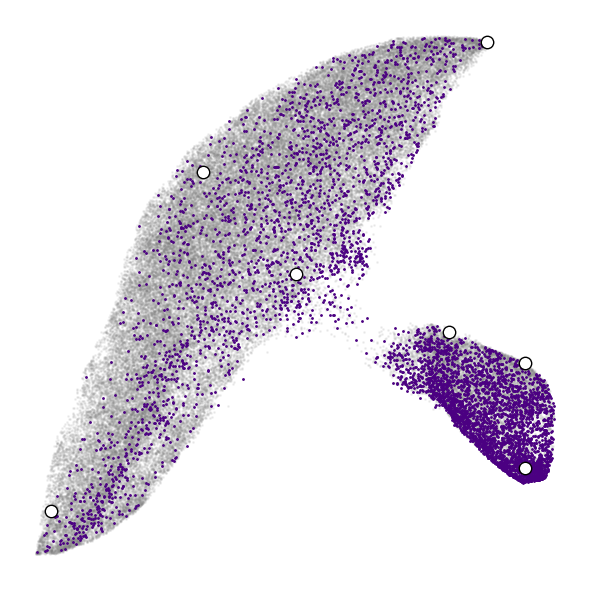

In [17]:
if annotations_to_use == 'manual':

    fig, ax = plt.subplots(figsize=(6, 6))

    sc = ax.scatter(
        features_n2[:, 0],
        features_n2[:, 1],
        s=1.,
        vmin=-2,
        vmax=2,
        alpha=0.1,
        color='gray',
        rasterized=True,
        label='All Synapses')
        
    sc = ax.scatter(
        features_n2[analysis_indices, 0],
        features_n2[analysis_indices, 1],
        s=1.,
        vmin=-2, vmax=2,
        alpha=1.,
        color='indigo',
        rasterized=True,
        label='Annotated Synapses')

    sc = ax.scatter(
        list(map(lambda x: x[0], highlighted_umap_pos_list)),
        list(map(lambda x: x[1], highlighted_umap_pos_list)),
        lw=1.0,
        s=80,
        facecolor='white',
        edgecolor='black')


    ax.set_xlabel(f'{embedding_type} 1', fontsize=14)
    ax.set_ylabel(f'{embedding_type} 2', fontsize=14)
    ax.axis('off')
    fig.tight_layout()
    fig.savefig(
        os.path.join(manual_umap_annotations_output_path, f'umap__{save_prefix}__blank_with_highlights.pdf'),
        dpi=600,
        bbox_inches='tight')

### Cleft size

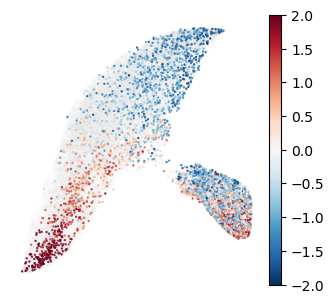

In [18]:
fig, ax = plt.subplots(figsize=panel_size)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')
    
sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=analysis_meta_ext_df['cleft_size_log1p_zscore'].values,
    s=s,
    vmin=-2,
    vmax=2,
    alpha=alpha,
    rasterized=True,
    cmap=plt.cm.RdBu_r)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__cleft_size.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

### Pre-synaptic process size

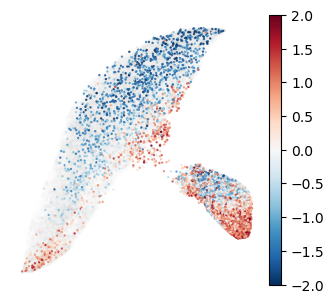

In [19]:
fig, ax = plt.subplots(figsize=panel_size)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=analysis_meta_ext_df['pre_synaptic_volume_log1p_zscore'].values,
    s=s,
    alpha=alpha,
    vmin=-2,
    vmax=2,
    rasterized=True,
    cmap=plt.cm.RdBu_r)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__pre_vol.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

### Post-synaptic process size

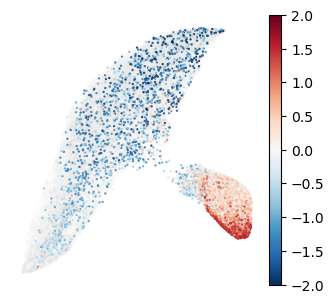

In [20]:
fig, ax = plt.subplots(figsize=panel_size)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=analysis_meta_ext_df['post_synaptic_volume_log1p_zscore'].values,
    s=s,
    alpha=alpha,
    vmin=-2,
    vmax=2,
    rasterized=True,
    cmap=plt.cm.RdBu_r)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__post_vol.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

### Pre-synaptic soma distance

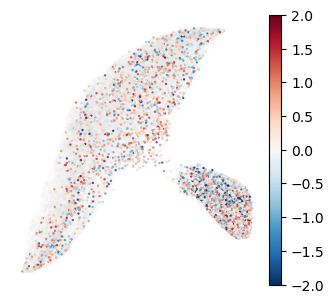

In [21]:
fig, ax = plt.subplots(figsize=panel_size)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=analysis_meta_ext_df['presyn_soma_dist_log1p_zscore'].values,
    s=s,
    alpha=alpha,
    vmin=-2,
    vmax=2,
    rasterized=True,
    cmap=plt.cm.RdBu_r)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__pre_soma_dist.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

### Post-synaptic soma distance

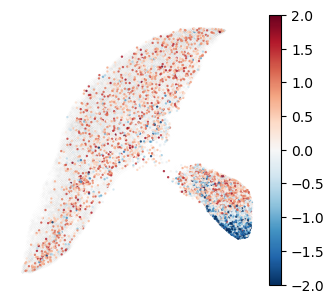

In [22]:
fig, ax = plt.subplots(figsize=panel_size)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=analysis_meta_ext_df['postsyn_soma_dist_log1p_zscore'].values,
    s=s,
    alpha=alpha,
    vmin=-2,
    vmax=2,
    rasterized=True,
    cmap=plt.cm.RdBu_r)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__post_soma_dist.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

### Pre-synaptic MT volume

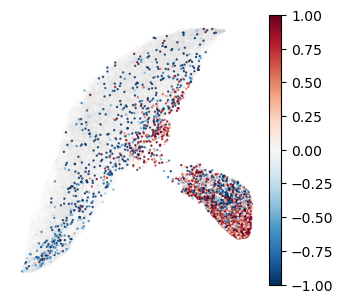

In [23]:
fig, ax = plt.subplots(figsize=panel_size)

mask = analysis_meta_ext_df['has_mito_pre'].values.astype(bool)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0][mask],
    features_n2[analysis_indices, 1][mask],
    c=analysis_meta_ext_df['mito_size_pre_vx_log1p_zscore_zi'].values[mask],
    s=s,
    alpha=alpha,
    vmin=-1,
    vmax=1,
    rasterized=True,
    cmap=plt.cm.RdBu_r)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__pre_mito_vol.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

### Post-synaptic MT volume

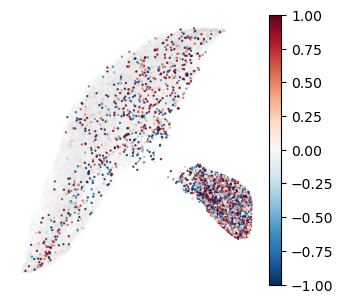

In [24]:
fig, ax = plt.subplots(figsize=panel_size)

mask = analysis_meta_ext_df['has_mito_post'].values.astype(bool)

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0][mask],
    features_n2[analysis_indices, 1][mask],
    c=analysis_meta_ext_df['mito_size_post_vx_log1p_zscore_zi'].values[mask],
    s=s,
    alpha=alpha,
    vmin=-1,
    vmax=1,
    rasterized=True,
    cmap=plt.cm.RdBu_r)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__post_mito_vol.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

### Has Pre-synaptic MT?

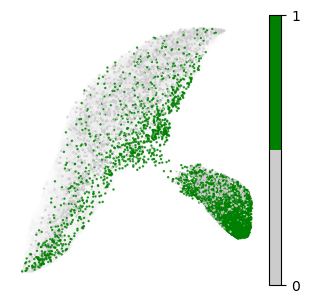

In [25]:
fig, ax = plt.subplots(figsize=panel_size)

mask = analysis_meta_ext_df['has_mito_pre'].values.astype(bool)

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap([(0.8, 0.8, 0.8), 'green'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask.astype(float),
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__has_pre_mito.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

### Has Post-synaptic MT?

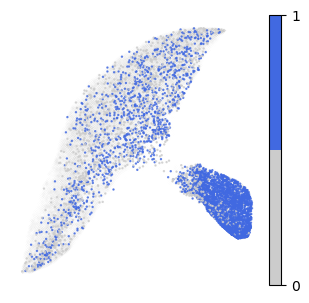

In [26]:
fig, ax = plt.subplots(figsize=panel_size)

mask = analysis_meta_ext_df['has_mito_post'].values

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap([(0.8, 0.8, 0.8), 'royalblue'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask,
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__has_post_mito.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

## Ex to Ex

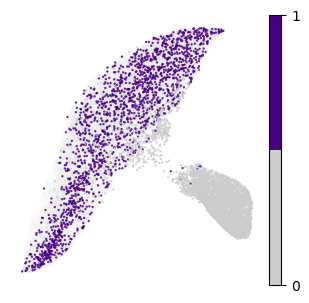

In [27]:
fig, ax = plt.subplots(figsize=panel_size)

mask = (analysis_meta_ext_df['pre_cell_type'].values == 0) & (analysis_meta_ext_df['post_cell_type'].values == 0)

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap([(0.8, 0.8, 0.8), 'indigo'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask,
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__cell_type__ex_to_ex.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

## Ex to In

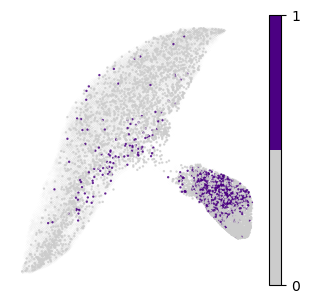

In [28]:
fig, ax = plt.subplots(figsize=panel_size)

mask = (analysis_meta_ext_df['pre_cell_type'].values == 0) & (analysis_meta_ext_df['post_cell_type'].values == 1)

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap([(0.8, 0.8, 0.8), 'indigo'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask,
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__cell_type__ex_to_in.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

## In to Ex

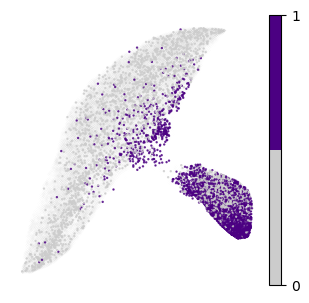

In [29]:
fig, ax = plt.subplots(figsize=panel_size)

mask = (analysis_meta_ext_df['pre_cell_type'].values == 1) & (analysis_meta_ext_df['post_cell_type'].values == 0)

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap([(0.8, 0.8, 0.8), 'indigo'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask,
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__cell_type__in_to_ex.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

## In to In

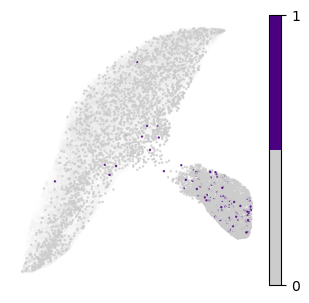

In [30]:
fig, ax = plt.subplots(figsize=panel_size)

mask = (analysis_meta_ext_df['pre_cell_type'].values == 1) & (analysis_meta_ext_df['post_cell_type'].values == 1)

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap([(0.8, 0.8, 0.8), 'indigo'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask,
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__cell_type__in_to_in.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

## Pre-synaptic cell type

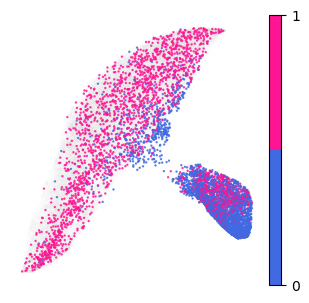

In [31]:
fig, ax = plt.subplots(figsize=panel_size)

mask = analysis_meta_ext_df['pre_cell_type'].values == 0

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap(['royalblue', 'deeppink'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask,
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__pre_cell_type.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)

## Post-synaptic cell type

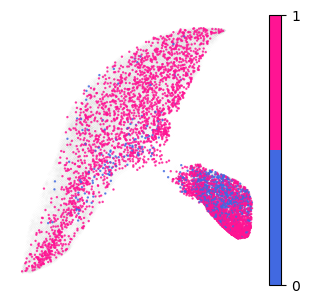

In [32]:
fig, ax = plt.subplots(figsize=panel_size)

mask = analysis_meta_ext_df['post_cell_type'].values == 0

import matplotlib.colors
binray_cmap = matplotlib.colors.ListedColormap(['royalblue', 'deeppink'])

sc = ax.scatter(
    features_n2[:, 0],
    features_n2[:, 1],
    s=0.01,
    vmin=-2, vmax=2,
    alpha=0.05,
    color='gray',
    rasterized=True,
    label='All Synapses')

sc = ax.scatter(
    features_n2[analysis_indices, 0],
    features_n2[analysis_indices, 1],
    c=mask,
    s=s,
    alpha=alpha,
    vmin=0,
    vmax=1,
    rasterized=True,
    cmap=binray_cmap)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_alpha(1.)
cbar.draw_all()
cbar.set_ticks([0, 1])

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(
    os.path.join(umap_annotations_output_path, output_subdir, f'umap__{save_prefix}__post_cell_type.pdf'),
    dpi=300,
    bbox_inches='tight',
    transparent=True)